In [43]:
symbol = 'BTCUSDT'
tf = '1d'

In [45]:
import pandas as pd
df = pd.read_csv(f'./{symbol}_{tf}.csv')
df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
df.set_index('Date',inplace=True)
df = df[['Open', 'High', 'Low', 'Close', 'Volume','Taker_buy_base']]
df.index = pd.to_datetime(df.index)

In [4]:
import pandas as pd
from ta.volume import OnBalanceVolumeIndicator
from ta.volatility import AverageTrueRange
from ta.trend import ADXIndicator

def add_indicators(df):
    df.columns = df.columns.str.capitalize()
    df['Delta_volume'] = df['Taker_buy_base'] - (df['Volume'] - df['Taker_buy_base'])
    df['cvd'] = df['Delta_volume'].cumsum()
    df['cvd_rolling'] = df['cvd'].rolling(12).mean()
    df['adx'] = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close']).adx()
    df['obv'] = OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()
    df['atr'] = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close']).average_true_range()
    df['cvd_momentum'] = df['cvd_rolling'] - df['cvd_rolling'].shift(5)

    df['ret_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['ret_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['ret_15'] = df['Close'] / df['Close'].shift(15) - 1

    df['vol_compression'] = df['atr'] / df['Close'].rolling(14).std()

    df.dropna(inplace=True)  
    # df['lower_wick'] = df[['Close', 'Open']].min(axis=1) -  df['Low']
    # df['upper_wick'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    # df['body_size'] = df['Close'] - df['Open']
    df.drop(columns=['High', 'Open', 'Low', 'Volume', 'Taker_buy_base','cvd','Delta_volume'], inplace=True)
    
    return df


In [5]:
data = add_indicators(df)
data

,Close,cvd_rolling,adx,obv,atr,cvd_momentum,ret_5,ret_10,ret_15,vol_compression
Date,,,,,,,,,,
2024-06-01 16:00:00,67700.01,-237.753074,0.000000,1780.806890,155.969056,-40.879645,0.000583,0.000099,0.002072,3.662832
2024-06-01 17:00:00,67791.02,-242.372582,0.000000,2957.969700,169.348409,-24.785559,0.001082,0.002350,0.000915,3.419627
2024-06-01 18:00:00,67750.71,-246.095963,0.000000,2680.859010,164.067094,-19.696533,0.000453,0.000690,0.000523,3.229202
2024-06-01 19:00:00,67753.76,-247.589324,0.000000,2855.386990,159.270873,-16.216798,-0.000731,0.000695,0.001090,3.064132
2024-06-01 20:00:00,67796.54,-251.900803,0.000000,3192.570940,154.790096,-15.314052,0.001555,0.002502,0.001628,2.742979
...,...,...,...,...,...,...,...,...,...,...
2025-05-31 20:00:00,104781.83,-212773.192200,29.743272,78218.335698,431.487659,-66.851490,0.002159,0.013266,0.012004,0.885405
2025-05-31 21:00:00,104863.16,-212784.971920,28.191980,78535.597858,417.697826,-61.764150,0.003566,0.013188,0.009634,0.820176
2025-05-31 22:00:00,104625.80,-212792.829510,26.601996,78307.490948,409.070839,-57.553752,0.002652,0.005689,0.008470,0.831547


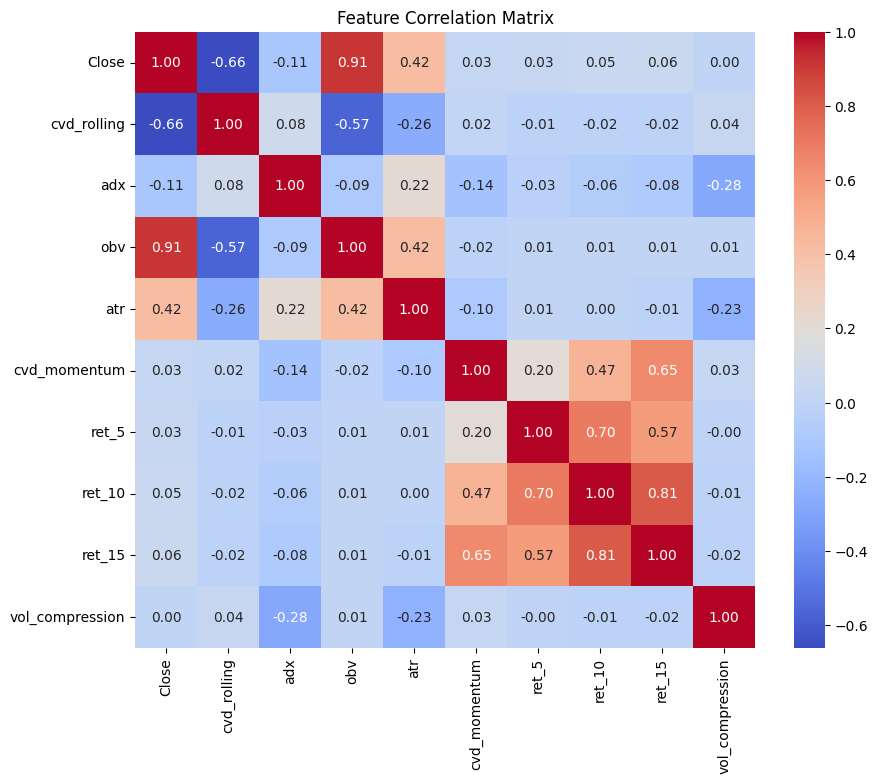

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataframe with OHLCV + indicators
correlation_matrix = data.corr()

# Visualize
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [24]:
def add_target_column(df, lookahead=50):
    target = []

    for i in range(len(df)):
        start_price = df['Close'].iloc[i]
        valid_bars = df.iloc[i+1:i+1+lookahead]
        max_percent = -1

        for j in range(len(valid_bars)):
            curr_price = valid_bars['Close'].iloc[j]
            max_percent =  max(max_percent,(curr_price - start_price) / start_price)
        
        target.append(max_percent)

    df_copy = df.copy()
    df_copy['Target'] = target
    df_target = df_copy[['Target']]
    return df_target


In [25]:
df_target = add_target_column(data,lookahead=10)

In [26]:
data = pd.concat([data, df_target], axis=1)
data = data[:-10]

In [27]:
data.describe()

,Close,cvd_rolling,adx,obv,atr,cvd_momentum,ret_5,ret_10,ret_15,vol_compression,Target,Target
count,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000
mean,80705.422022,-103803.447477,27.189480,-12062.573670,588.251830,-121.424066,0.000316,0.000634,0.000954,1.389818,0.009373,0.008806
std,16825.554318,63765.704536,11.635643,88321.382221,274.982423,395.781515,0.012002,0.016828,0.020557,0.652323,0.011380,0.012031
min,49804.000000,-212228.616774,0.000000,-183422.953660,111.522913,-3500.505373,-0.082175,-0.127962,-0.148067,0.301554,0.000000,-0.035121
25%,64084.430000,-168741.006430,18.411563,-97036.141920,402.730516,-275.783653,-0.004945,-0.007207,-0.009106,0.925513,0.001444,0.001444
50%,83489.950000,-85126.642249,25.050575,21350.072718,524.280519,-100.067292,0.000277,0.000562,0.000543,1.278032,0.005937,0.005937
75%,96395.880000,-59965.959111,33.518165,59613.762433,716.198220,53.158563,0.005721,0.008655,0.011294,1.727373,0.012906,0.012906
max,111780.840000,1227.566673,71.372379,122045.597141,2224.645832,2077.379936,0.098870,0.099861,0.117696,6.870620,0.108364,0.108364


In [28]:
X = data.drop(columns=['Target'])
y = data['Target']

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [30]:
scaled_X[0]

array([-0.77300023,  1.62425289, -2.33687461,  0.1567477 , -1.57212794,
        0.20351895,  0.02226224, -0.03178545,  0.0543894 ,  3.48468963])

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=42, shuffle=False)

In [33]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression()

In [34]:
from sklearn.metrics import mean_squared_error,r2_score
y_pred = clf.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print(f'Mean Squared Error on training set: {mse}')
r2 = r2_score(y_train, y_pred)
print(f'R^2 on training set: {r2}')

Mean Squared Error on training set: 0.0001245266111128601
R^2 on training set: 0.07863241454710168


In [35]:
from sklearn.metrics import mean_squared_error
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on training set: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R^2 on training set: {r2}')

Mean Squared Error on training set: 0.0001503817404571548
R^2 on training set: -0.061580079247327


Mean Squared Error on test set: 0.00041006165918011823
R^2 score on test set: -1.8983909171176967


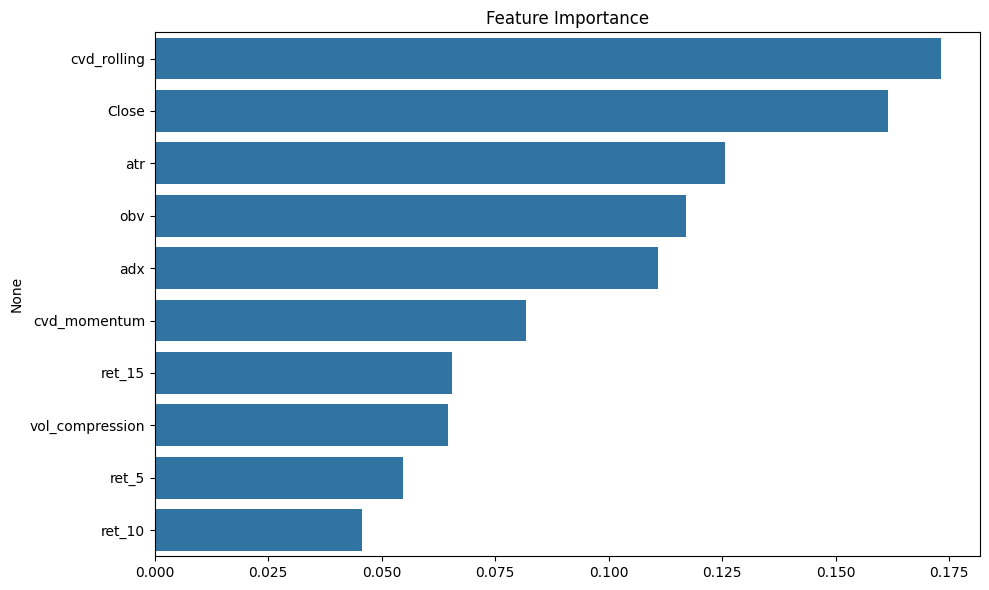

In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = rf.score(X_test, y_test)

print(f'Mean Squared Error on test set: {mse}')
print(f'R^2 score on test set: {r2}')

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()
